### 使用pythorch加速运算的lowrankSNN
#### lowrank 给EtoE的连接
#### 视synaptic current为活动
#### 添加bias current

In [13]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch.distributions as dist
from functions import Generate_Vectors, Generate_RandomMatrix
from functions import show_mn, show_conn
from functions import Draw_Output, Draw_Conductance,  load_config_yaml, Draw_RasterPlot, Draw_Voltage, Draw_Projection, save_model
from functions import plot_peak_envelope, peak_envelope
from functions import load_init
from lowranksnn import LowRankSNN
from scipy.interpolate import interp1d
from sklearn.isotonic import IsotonicRegression

plt.rcParams.update({'font.size': 30})  


In [14]:
# Read the configuration file
# config = load_config_yaml('config.yaml')
# config = load_config_yaml('config_ING_gamma.yaml')
# config = load_config_yaml('config_go_nogo_diff.yaml')
config = load_config_yaml('./configures/config_test.yaml')
# config = load_config_yaml('./configures/config_test_par.yaml')
# config = load_config_yaml('./configures/config_test_phase_sensitivity.yaml')

N_E = config['N_E']
N_I = config['N_I']
N = N_E + N_I
P_EE = config['P_EE']
P_EI = config['P_EI']
P_IE = config['P_IE']
P_II = config['P_II']
factor_mn = config['factor_mn'] # 组合成conn时乘在lowrank matrix上的常數
RS = config['RandomStrength'] # 组合成conn时乘在random matrix上的常數

taud_E = config['taud_E']
taud_I = config['taud_I']
# ratio_fast = config['ratio_fast']
# if type(taud_E) == list: # introduce fast and slow time constants
#     mask_tauE = torch.rand(1, N_E) < ratio_fast
#     mask_tauI = torch.rand(1, N_I) < ratio_fast
#     tau_E = torch.ones(1, N_E) * taud_E[1]
#     tau_E[mask_tauE] = taud_E[0]
#     tau_I = torch.ones(1, N_I) * taud_I[1]
#     tau_I[mask_tauI] = taud_I[0]
#     taud_E = tau_E.tolist()
#     taud_I = tau_I.tolist()

eta_E = config['eta_E']
eta_I = config['eta_I']
delta_E = config['delta_E']
delta_I = config['delta_I']

mu = config['mu']
si = config['sigma']
# mu_rand = config['mu_rand']

si_rand = config['sigma_rand']
dt = config['dt'] #(ms/step)
T_pre = config['T_pre'] # length of time before sti (ms)
T_sti = config['T_sti'] # length of time for sti (ms)
T_after = config['T_after'] # length of time after sti (ms)
T = T_pre+T_sti+T_after # length of Period time (ms): 30ms

IS = config['InputStrength'] #Input Strength (maybe chage to norm in the future)

color_Go = config['color_Go']
color_Nogo = config['color_Nogo']


In [15]:
# Initialiazation
LRSNN = LowRankSNN(N_E=N_E,N_I=N_I,taud_E=taud_E,taud_I=taud_I,RS=RS)

# Go_NoGo Task
# Prepare the Low Rank Connectivity (Rank = 1), Stimuli and Readout Vector

# m, n, Sti_nogo = Generate_Vectors(N, mu, si)
bias_E = eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))
# # check the dtype of bias_E and n
# print(bias_E.dtype)
# print(n.dtype) 
# change the dtype of bias_E into float32
bias_E = bias_E.float()
# print(torch.dot(n[:N_E,0],bias_E).abs())
# filter the m, n, Sti_nogo
i = 0
while i<100:
    m_test, n_test, Sti_nogo_test = Generate_Vectors(N, mu, si)
    # if torch.sum(m_test[:N_E]).abs() < 1 and torch.sum(n_test[:N_E]).abs() < 1 and torch.sum(Sti_nogo_test[:N_E]).abs() < 1 and torch.dot(n_test[:N_E,0],bias_E).abs() < 1:
    if torch.sum(m_test[:N_E]).abs() < 1 and torch.sum(n_test[:N_E]).abs() < 1 and torch.sum(Sti_nogo_test[:N_E]).abs() < 1:
        print(N,mu,si)
        # sum of all the element in m and n and Sti_nogo_test
        print(torch.sum(m_test[:N_E]))
        print(torch.sum(n_test[:N_E]))
        print(torch.sum(Sti_nogo_test[:N_E]))
        print(torch.dot(n_test[:N_E,0],bias_E))
        print('i:',i)
        print('-----------------------------------')
        m = m_test
        n = n_test
        Sti_nogo = Sti_nogo_test
        break
    i += 1
    if i == 100:
        m = None
        n = None
        i = 0 
        print('did not find the suitable m, n, Sti_nogo')

m[N_E:] = 0
n[N_E:] = 0
Sti_nogo[N_E:] = 0
Sti_go = n.clone()
W_out = m.clone()


W_rank1 = factor_mn*torch.ger(m.squeeze(), n.squeeze())
conn_rand = Generate_RandomMatrix(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = si_rand)
def Generate_RandomMatrix_average(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = None):
    W = torch.zeros(N_E+N_I,N_E+N_I)
    W[:N_E,:N_E] = P_EE
    W[:N_E,N_E:] = P_EI
    W[N_E:,:N_E] = P_IE
    W[N_E:,N_E:] = P_II
    return W

def Generate_RandomMatrix_assign(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = None):
    # assign connection accoridng to P
    W = torch.rand(N_E+N_I,N_E+N_I)
    W_EE = W[:N_E,:N_E]
    W_EI = W[:N_E,N_E:]
    W_IE = W[N_E:,:N_E]
    W_II = W[N_E:,N_E:]
    W_EE = W_EE < P_EE
    W_EI = W_EI < P_EI
    W_IE = W_IE < P_IE
    W_II = W_II < P_II
    W[:N_E,:N_E] = W_EE.float()
    W[:N_E,N_E:] = W_EI.float()
    W[N_E:,:N_E] = W_IE.float()
    W[N_E:,N_E:] = W_II.float()
    return W
    

# make it all average and delete the low rank connection
# conn_rand = Generate_RandomMatrix_average(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = si_rand)
# conn_rand = Generate_RandomMatrix_assign(N_E, N_I, P_EE, P_EI, P_IE, P_II, W_rank1, sigma = si_rand)
# W_rank1 = torch.zeros_like(W_rank1)


# W_rank1 = torch.abs(W_rank1)
Sti_go = n.clone()
# show_conn(N,N_E, N_I, P_EE, P_EI, P_IE, P_II,W_rank1,RS,W_random=conn_rand)

# # delete the connection between E and I
# W_rank1[:N_E,N_E:] = 0
# W_rank1[N_E:,:N_E] = 0
# conn_rand[:N_E,N_E:] = 0
# conn_rand[N_E:,:N_E] = 0


did not find the suitable m, n, Sti_nogo
1000 0 0.2
tensor(0.7918)
tensor(0.5035)
tensor(-0.1646)
tensor(2.9262)
i: 76
-----------------------------------


In [16]:
# Assemble the Network
LRSNN.add_lowrank(W_rank1, W_out)
LRSNN.add_random(conn_rand)
# LRSNN.add_random(torch.zeros(N,N))
LRSNN.conn[LRSNN.conn>1] = 1
LRSNN.conn[LRSNN.conn<0] = 0

Low Rank connection and readout vector have been added.
Random connection has been added.


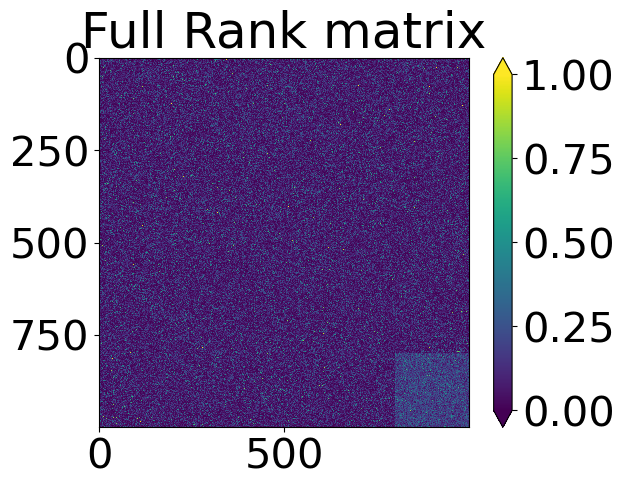

Full Rank matrix average value_EtoE: tensor(0.0999)
Full Rank matrix average value_EtoI: tensor(0.1000)
Full Rank matrix average value_ItoE: tensor(0.1001)
Full Rank matrix average value_ItoI: tensor(0.1987)


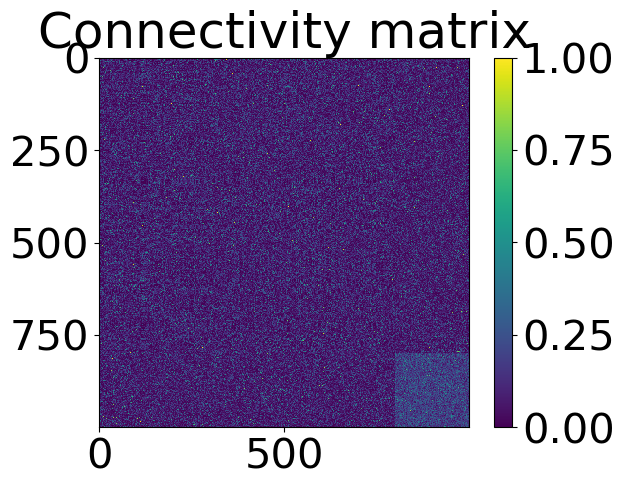

Connectivity matrix average value_EtoE: tensor(0.1028)
Connectivity matrix average value_EtoI: tensor(0.1000)
Connectivity matrix average value_ItoE: tensor(0.1000)
Connectivity matrix average value_ItoI: tensor(0.1987)


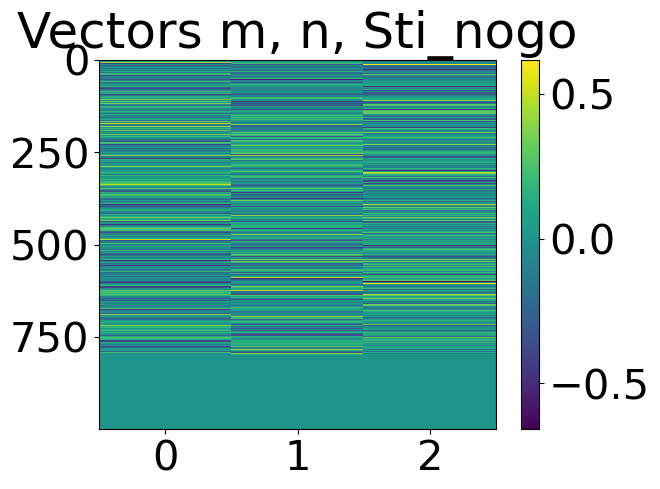

m norm: tensor(5.7293)
n norm: tensor(5.4846)
Sti_nogo norm: tensor(5.6937)


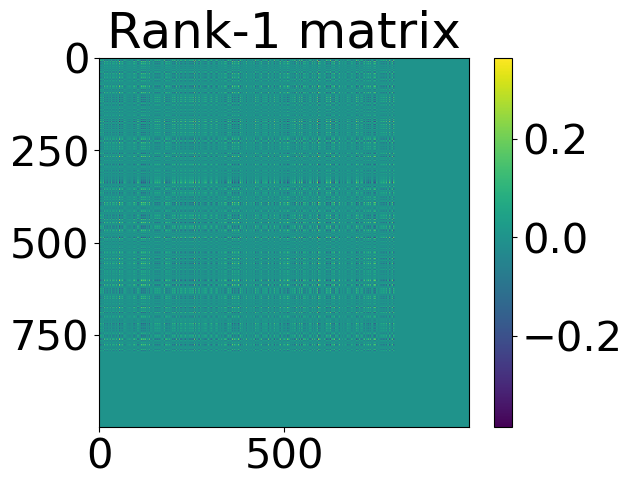

Rank-1 matrix average value_EtoE: tensor(6.2294e-07)
Rank-1 matrix average value_EtoI: tensor(0.)
Rank-1 matrix average value_ItoE: tensor(0.)
Rank-1 matrix average value_ItoI: tensor(0.)


tensor([[ 0.0128, -0.0205, -0.0144,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0289, -0.0463, -0.0326,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0186,  0.0299,  0.0210,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [17]:
show_conn(N,N_E, N_I, P_EE, P_EI, P_IE, P_II,W_rank1,RS,W_random=conn_rand)
def show_mn(m,n,Sti_nogo,factor_mn,N_E):

    # draw the vectors m, n, Sti_nogo in heatmap
    plt.figure()
    plt.imshow(torch.cat((m, n, Sti_nogo), 1), aspect='auto',interpolation='nearest')
    plt.colorbar()
    plt.title('Vectors m, n, Sti_nogo')
    plt.show()
    print("m norm:", torch.norm(m))
    print("n norm:", torch.norm(n))
    print("Sti_nogo norm:", torch.norm(Sti_nogo))

    W_rank1 = factor_mn*(torch.ger(m.squeeze(), n.squeeze()))
    # W_rank1 = factor_mn*torch.abs(torch.ger(m.squeeze(), n.squeeze()))
    # W_rank1 = factor_mn*torch.ger(m.squeeze(), n.squeeze())
    #draw the rank-1 matrix
    plt.figure()
    plt.imshow(W_rank1,interpolation='nearest')
    plt.colorbar()
    plt.title('Rank-1 matrix')
    plt.show()
    # 展示各部分的平均值
    print("Rank-1 matrix average value_EtoE:", torch.mean(W_rank1[:N_E, :N_E]))
    print("Rank-1 matrix average value_EtoI:", torch.mean(W_rank1[:N_E, N_E:]))
    print("Rank-1 matrix average value_ItoE:", torch.mean(W_rank1[N_E:, :N_E]))
    print("Rank-1 matrix average value_ItoI:", torch.mean(W_rank1[N_E:, N_E:]))
    return W_rank1
show_mn(m,n,Sti_nogo,1,N_E)

In [18]:
T = T_pre+T_sti+T_after # length of Period time (ms）

Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = Sti_go
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = Sti_nogo

# # duplicate the input for twice
# Input_go = torch.cat((Input_go,Input_go),1)
# Input_nogo = torch.cat((Input_nogo,Input_nogo),1)

# bias current (according to sugino's code)
# Eta = [0, 10]; % 定常電流の平均値
# Delta = [0, 0.05]; % 定常電流のHMHW
# I_E = Eta(1)+Delta(1)*tan(pi*((1:N_E)'/(N_E+1)-1/2)); % 流入電流(E)
# I_I = Eta(2)+Delta(2)*tan(pi*((1:N_I)'/(N_I+1)-1/2)); % 流入電流(I)
bias = torch.zeros_like(Input_go)
bias[:N_E,:] = (eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))).unsqueeze(1)
bias[N_E:,:] = (eta_I+delta_I*torch.tan(torch.tensor(np.pi*(np.arange(1,N_I+1)/(N_I+1)-1/2)))).unsqueeze(1)

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)
bias = bias.to(device)

# Start Simulation
Out_go, V_go, g_go, I_syn_go, spk_step_go, spk_ind_go, spk_go, phase_go = LRSNN(dt,IS*Input_go+bias)
Out_nogo, V_nogo, g_nogo, I_syn_nogo, spk_step_nogo, spk_ind_nogo, spk_nogo, phase_nogo = LRSNN(dt,IS*Input_nogo+bias)


g_go_EE = g_go[1]
g_nogo_EE = g_nogo[1]

prop = torch.max(Out_go)/torch.max(Out_nogo)
print('Performance: ', prop.item())


Start Simulation
Simulation Finished
Start Simulation
Simulation Finished
Performance:  1.0


In [7]:
# load the predefined values into the model
# def load_init(LRSNN, T_pre, dt, g_ref, g_ref_EE, g_ref_EI, g_ref_IE, g_ref_II, V_ref, phase_ref, I_ref_syn, I_ref_syn_EE, I_ref_syn_EI, I_ref_syn_IE, I_ref_syn_II, spk_ref):
#     step_init = int(T_pre/dt)
#     g_init = g_ref[:,step_init].clone().detach()
#     g_init_EE = g_ref_EE[:,step_init].clone().detach()
#     g_init_EI = g_ref_EI[:,step_init].clone().detach()
#     g_init_IE = g_ref_IE[:,step_init].clone().detach()
#     g_init_II = g_ref_II[:,step_init].clone().detach()
#     V_init = V_ref[:,step_init].clone().detach()
#     phase_init = phase_ref[:,step_init].clone().detach()
#     I_syn_init = I_ref_syn[:,step_init].clone().detach()
#     I_syn_init_EE = I_ref_syn_EE[:,step_init].clone().detach()
#     I_syn_init_EI = I_ref_syn_EI[:,step_init].clone().detach()
#     I_syn_init_IE = I_ref_syn_IE[:,step_init].clone().detach()
#     I_syn_init_II = I_ref_syn_II[:,step_init].clone().detach()
#     spk_init = spk_ref[:,step_init]
#     LRSNN.load_init(g_init, g_init_EE, g_init_EI, g_init_IE, g_init_II, V_init, phase_init, I_syn_init, I_syn_init_EE, I_syn_init_EI, I_syn_init_IE, I_syn_init_II, spk_init)
#     return LRSNN

LRSNN = load_init(LRSNN, T-dt, dt, g_go[0], g_go[1], g_go[2], g_go[3], g_go[4], V_go, phase_go, I_syn_go[0], I_syn_go[1], I_syn_go[2], I_syn_go[3], I_syn_go[4], spk_go)


Initial values have been loaded.


In [19]:
# 处理绘图用的数据以使其能够在cpu上运行
Out_go = Out_go.cpu().numpy()
Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = [g.cpu().numpy() for g in g_go]
g_nogo = [g.cpu().numpy() for g in g_nogo]
g_go_EE = g_go[1]
g_nogo_EE = g_nogo[1]
V_go = V_go.cpu().numpy()
V_nogo = V_nogo.cpu().numpy()
I_syn_go = [I.cpu().numpy() for I in I_syn_go]
I_syn_nogo = [I.cpu().numpy() for I in I_syn_nogo]
I_syn_go_EE = I_syn_go[1]
I_syn_nogo_EE = I_syn_nogo[1]

spk_go = spk_go.cpu().numpy()
spk_nogo = spk_nogo.cpu().numpy()
m = m.cpu().numpy()
n = n.cpu().numpy()
Sti_go = Sti_go.cpu().numpy()
Sti_nogo = Sti_nogo.cpu().numpy()

(-9.48419451713562, 10.810855627059937)

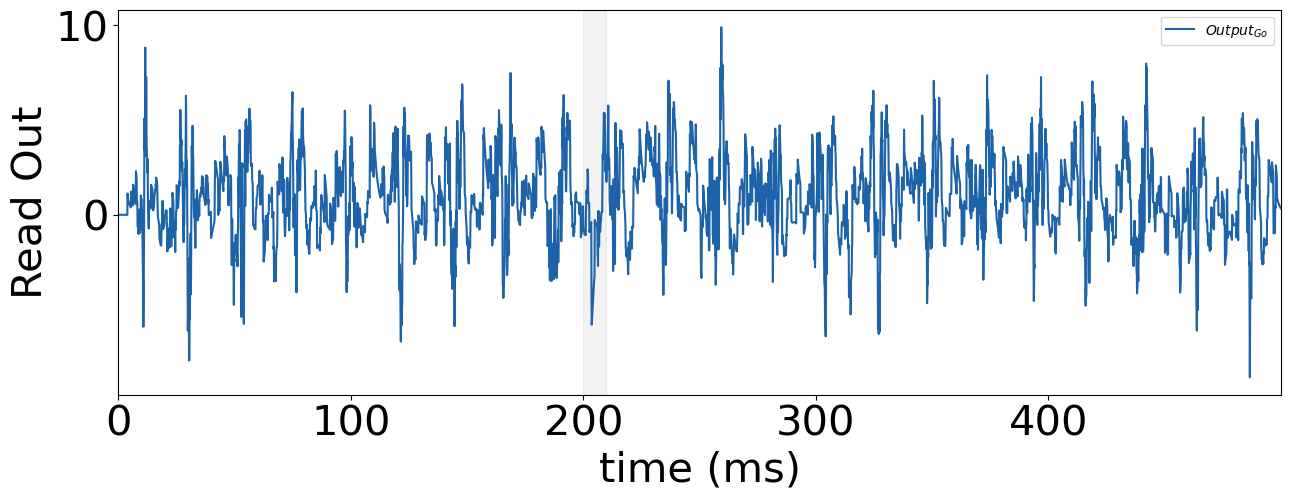

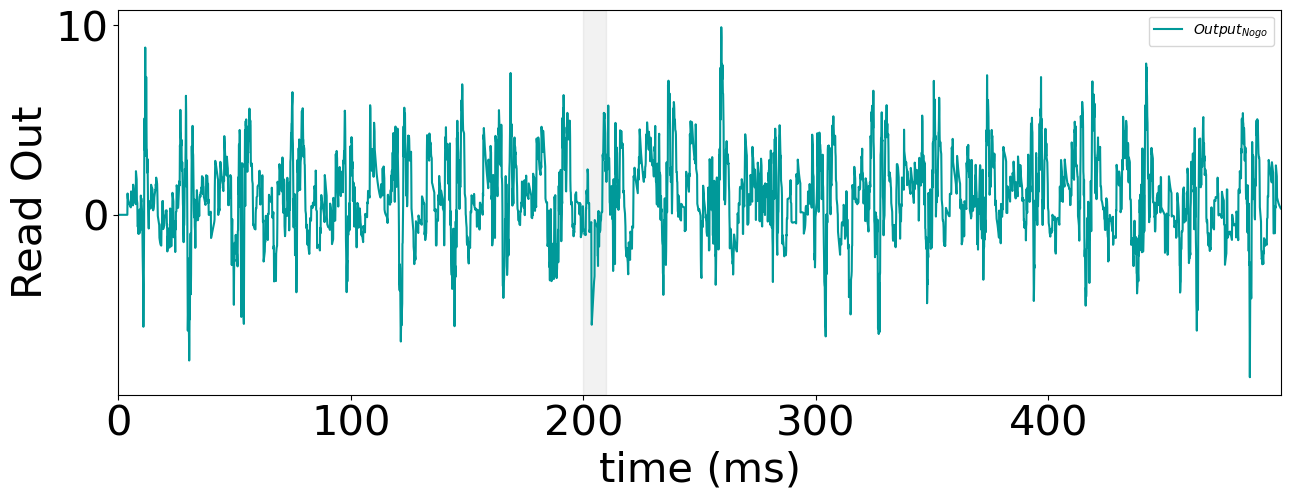

In [20]:
# Draw Output
fig, ax = plt.subplots(figsize=(15,5))
ylim = Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)
fig, ax = plt.subplots(figsize=(15,5))
Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo,ylim=ylim)


(-4.888976669311524, 102.66851005554199)

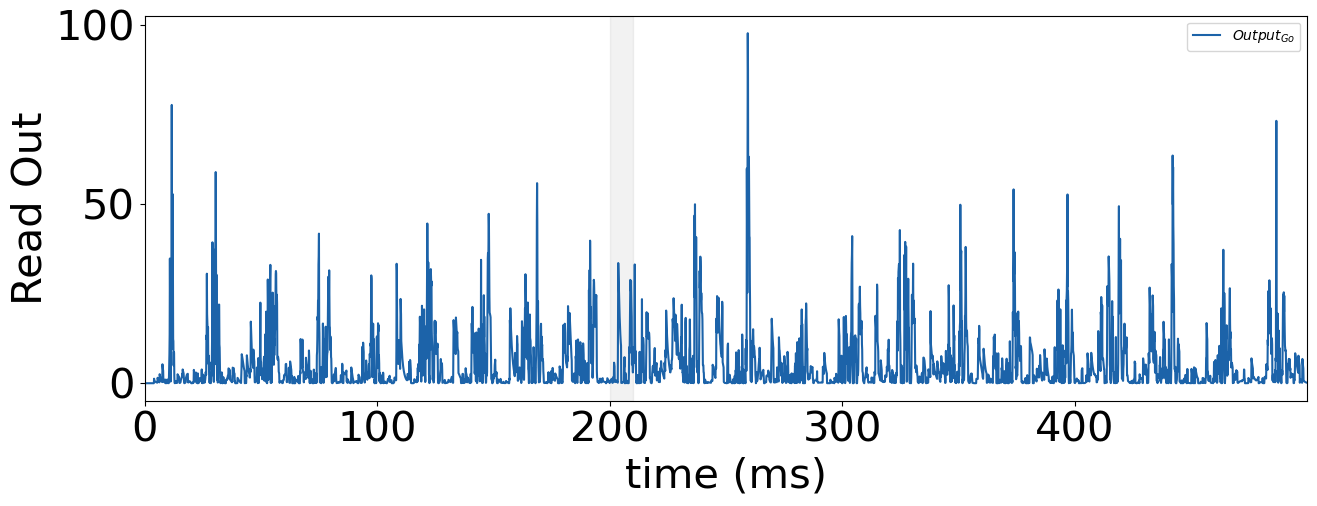

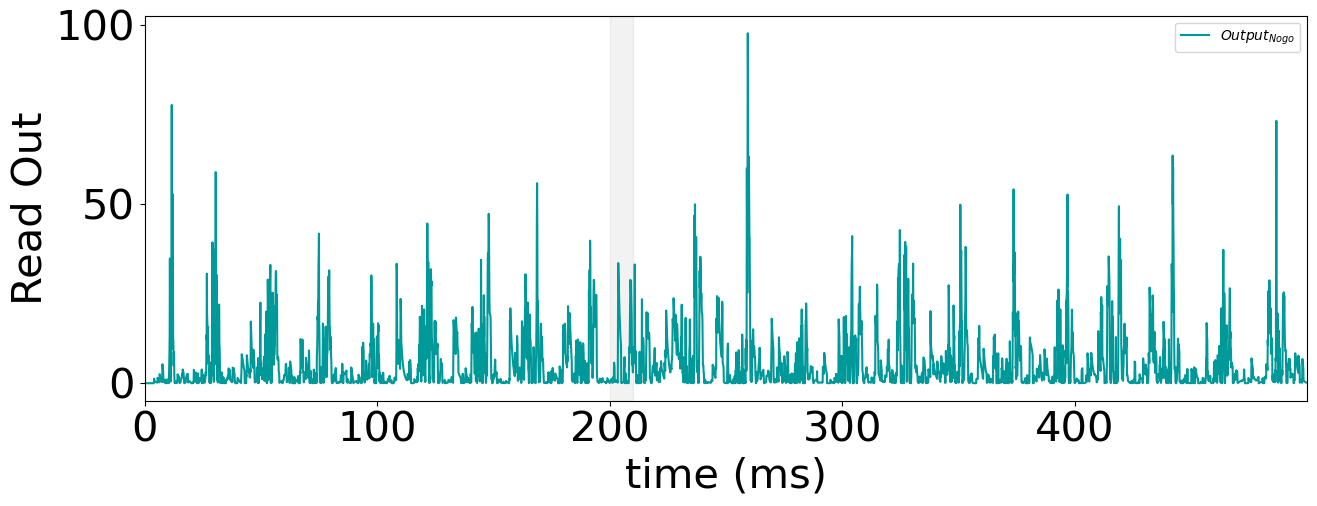

In [21]:
go_signal = Out_go.copy().squeeze()
nogo_signal = Out_nogo.copy().squeeze()
# Draw Output
fig, ax = plt.subplots(figsize=(15,5))
ylim = Draw_Output(ax,go_signal**2,'Output_{Go}',dt,Input_go,color_data = color_Go)
fig, ax = plt.subplots(figsize=(15,5))
Draw_Output(ax,nogo_signal**2,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo,ylim=ylim)

Text(0.5, 0, 'Time (ms)')

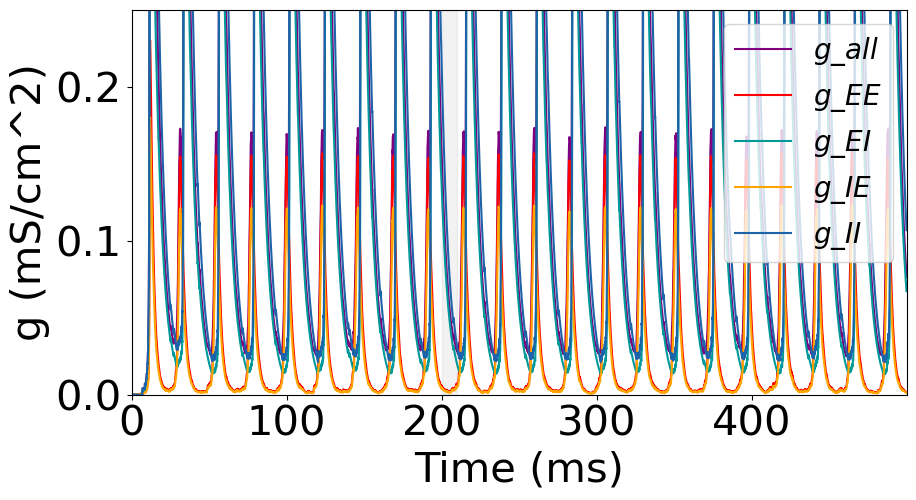

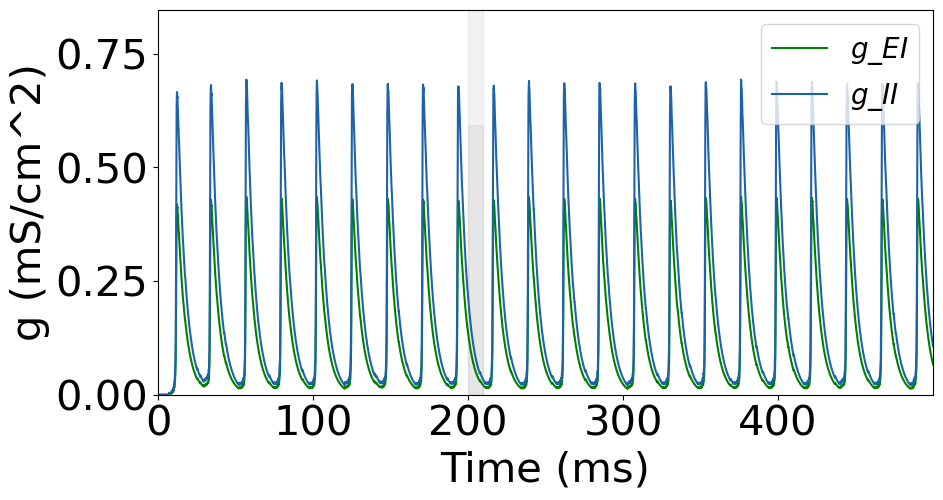

In [22]:

# Monitor the Average Conductance
# Average of summary of synaptic conductance from a group of neurons to a single neuron
tag = ['g\_all','g\_EE','g\_EI','g\_IE','g\_II']
colors = ['#800080','#FF0000','#009999','#FFA500','#1C63A9']
# y_lim = [0,1.5]
y_lim = [0,0.25]
# y_lim = [0,6]
fig, ax = plt.subplots(figsize=(10,5))
# Draw_Conductance(ax,g_go,colors,tag,dt,Input_go,ylim=y_lim,title="Synaptic Conductance for Go")
Draw_Conductance(ax,g_go,colors,tag,dt,Input_go,ylim=y_lim)
ax.legend(loc = 1, prop={'size':20})
ax.set_xlabel('Time (ms)')
# fig, ax = plt.subplots(figsize=(10,5))
# # Draw_Conductance(ax,g_nogo,colors,tag,dt,Input_nogo,ylim=y_lim,title="Synaptic Conductance for NoGo")
# Draw_Conductance(ax,g_nogo,colors,tag,dt,Input_nogo,ylim=y_lim)
# ax.legend(loc = 1, prop={'size':20})


# fig, ax = plt.subplots(figsize=(10,5))
# # Draw_Conductance(ax,g_go,colors,tag,dt,Input_go,ylim=y_lim,title="Synaptic Conductance for Go")
# Draw_Conductance(ax,g_go[1],'#800080','g\_EE',dt,Input_go,ylim=y_lim)
# ax.legend(loc = 1, prop={'size':20})
# ax.set_xlabel('Time (ms)')

fig, ax = plt.subplots(figsize=(10,5))
# Draw_Conductance(ax,g_go,colors,tag,dt,Input_go,ylim=y_lim,title="Synaptic Conductance for Go")
# Draw_Conductance(ax,g_go[-1],'#1C63A9','g\_II',dt,Input_go,ylim=y_lim)

# Draw_Conductance(ax,g_go[1],'red','g\_EE',dt,Input_go)
Draw_Conductance(ax,g_go[2],'green','g\_EI',dt,Input_go)
# Draw_Conductance(ax,g_go[3],'blue','g\_IE',dt,Input_go)
Draw_Conductance(ax,g_go[4],'#1C63A9','g\_II',dt,Input_go)
ax.legend(loc = 1, prop={'size':20})
ax.set_xlabel('Time (ms)')


Text(0.5, 0, 'Time (ms)')

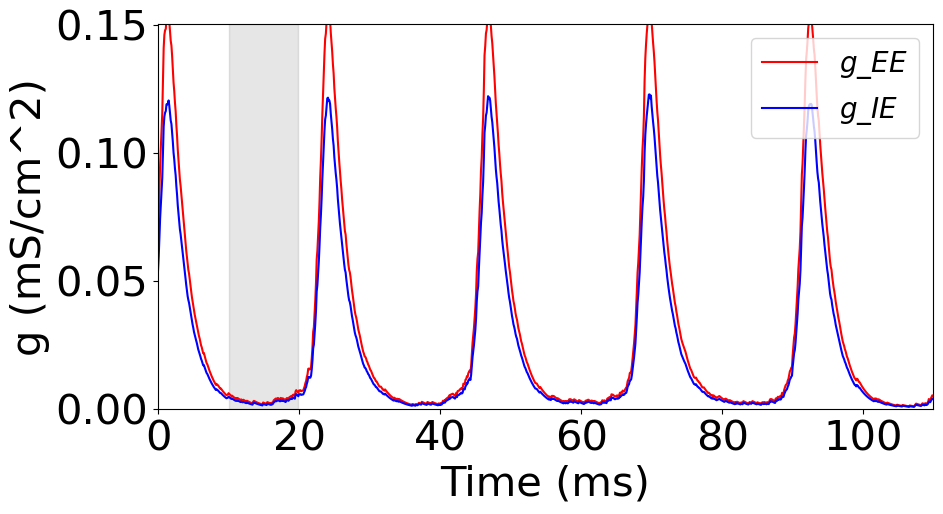

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
start = 1900
end = 3000
Draw_Conductance(ax,g_go[1][:,start:end],'red','g\_EE',dt,Input_go[:,start:end])
Draw_Conductance(ax,g_go[2][:,start:end],'green','g\_EI',dt,Input_go[:,start:end])
Draw_Conductance(ax,g_go[3][:,start:end],'blue','g\_IE',dt,Input_go[:,start:end])
Draw_Conductance(ax,g_go[4][:,start:end],'#1C63A9','g\_II',dt,Input_go[:,start:end])
ax.legend(loc = 1, prop={'size':20})
ax.set_xlabel('Time (ms)')



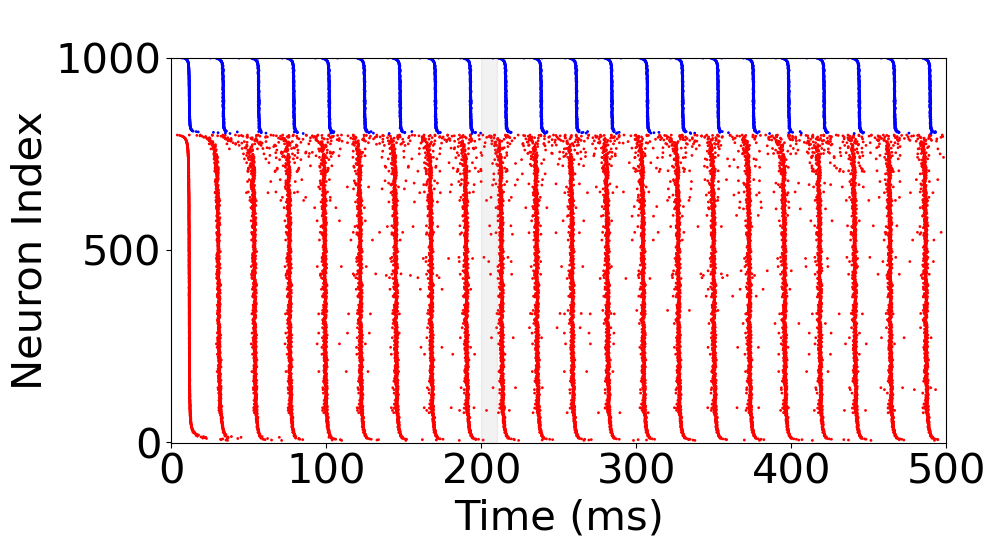

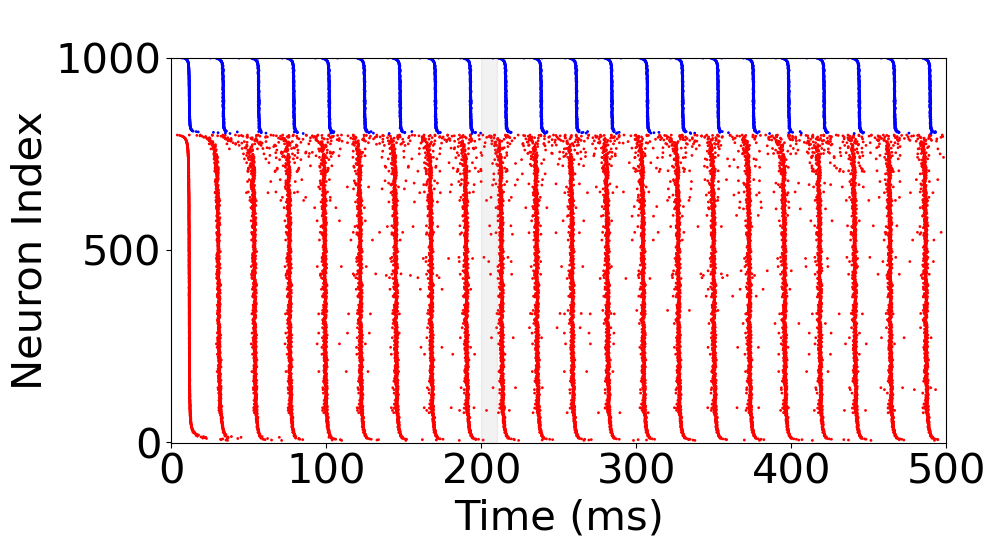

In [24]:
# Raster Plot
def Draw_RasterPlot(ax, spk_step, spk_ind, title_name, dt, input_data, N_E, N_I):
    tt = np.array(range(len(input_data[0])))*dt

    # 预先计算需要绘制的点和颜色
    x_values = np.array(spk_step) * dt
    colors = ['blue' if ind >= N_E else 'red' for ind in spk_ind]
    # 一次性绘制所有点
    ax.scatter(x_values, spk_ind, c=colors, s=1)

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Neuron Index')

    ax.set_xlim([0, len(input_data[0])*dt])
    ax.set_ylim([-1, N_E+N_I])

    non_zero_columns = np.any(input_data!=0, axis=0)
    non_zero_columns = np.where(non_zero_columns)[0]
    start_sti = non_zero_columns[0]*dt
    end_sti = non_zero_columns[-1]*dt
    ax.fill_between(tt, ax.get_ylim()[0], ax.get_ylim()[1], where=input_data[0].squeeze()!=0, color='gray', alpha=0.1)
    # ax.legend(loc = 1, prop={'size':10})
    ax.set_title(title_name)

fig, ax = plt.subplots(figsize=(10,5))
Draw_RasterPlot(ax,spk_step_go, spk_ind_go,' ',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
fig, ax = plt.subplots(figsize=(10,5))
Draw_RasterPlot(ax,spk_step_nogo,spk_ind_nogo,' ',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())


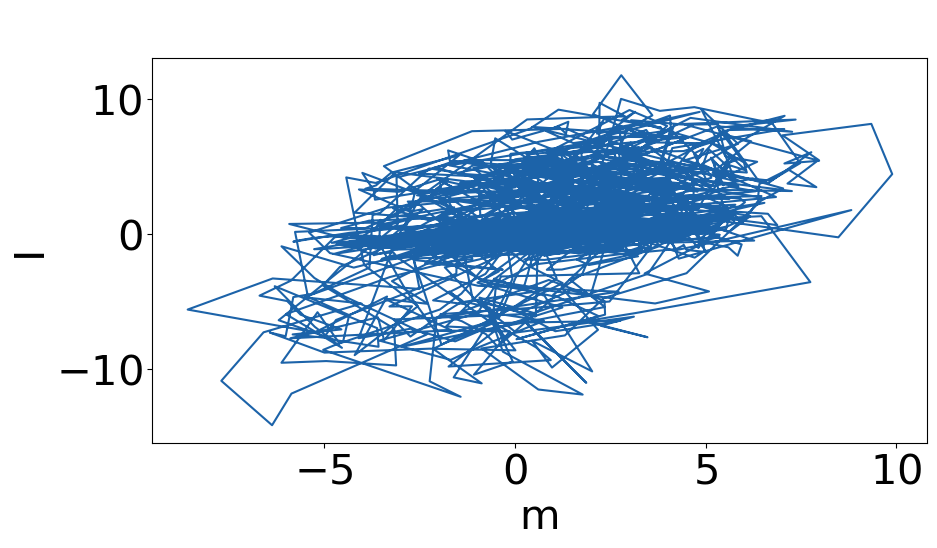

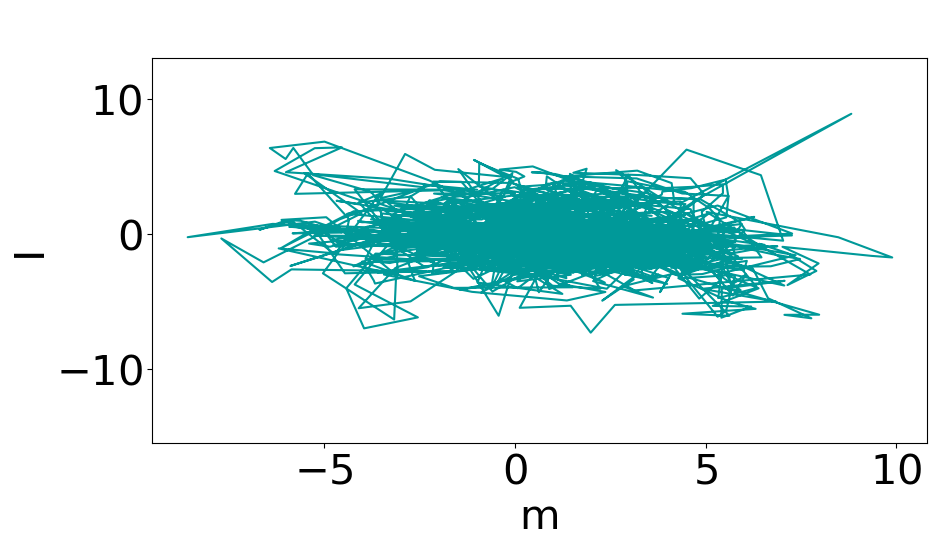

In [25]:
# Monitor the Projection on m-I plane
from matplotlib.ticker import FuncFormatter, ScalarFormatter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def Draw_Projection(ax, activity, direction1, direction2, 
                    title_name='Projection', color_line='#1C63A9', 
                    xlabel='Activity along Direction1', ylabel='Activity along Direction2', 
                    ylim=None, xlim=None):
    """
    绘制 activity 在两个方向上的投影。

    参数：
    - ax: matplotlib.axes.Axes 对象
    - activity: numpy.ndarray, 形状 (N, T)
    - direction1: numpy.ndarray, 形状 (N, 1) 或 (N,)
    - direction2: numpy.ndarray, 形状 (N, 1) 或 (N,)
    - title_name: str, 图表标题
    - color_line: str, 线条颜色
    - xlabel: str, x 轴标签
    - ylabel: str, y 轴标签
    - ylim: tuple or None, y 轴范围
    - xlim: tuple or None, x 轴范围

    返回：
    - (ylim, xlim): 设定的 y 轴和 x 轴范围
    """

    # 确保 ax 是 matplotlib 轴对象
    if not isinstance(ax, plt.Axes):
        raise TypeError("ax 必须是 matplotlib.axes.Axes 对象")

    # 确保 direction1 和 direction2 是列向量
    direction1 = np.asarray(direction1).reshape(-1, 1)
    direction2 = np.asarray(direction2).reshape(-1, 1)

    # 确保 activity 是 2D 数组
    activity = np.asarray(activity)
    if activity.ndim != 2:
        raise ValueError("activity 必须是二维数组，形状应为 (N, T)")

    # 计算投影（activity.T @ direction 得到 (T,1)）
    try:
        # torch.tanh(I_syn_EE).T@self.W_out[:self.N_E]
        # 用tanh函数做归一化
        act_on_dir1 = activity.T @ direction1  # 形状 (T, 1)
        act_on_dir2 = activity.T @ direction2  # 形状 (T, 1)
    except ValueError as e:
        raise ValueError(f"矩阵乘法失败，请检查形状：{e}")

    # 绘图
    ax.plot(act_on_dir1.ravel(), act_on_dir2.ravel(), color=color_line)

    # 设置坐标轴格式（科学计数法）
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_powerlimits((-3, 3))  # 科学计数法的阈值
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)

    # 设定标题和标签
    ax.set_title(title_name)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # 设定轴范围
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)

    return ax.get_ylim(), ax.get_xlim()

# 为了避免活动极端值的影响，我们可以使用双曲正切函数进行归一化
fig, ax = plt.subplots(figsize=(10,5))
# ylim,xlim = Draw_Projection(ax,I_syn_go_EE,m[:N_E].numpy(),Sti_go[:N_E].numpy(),' ',color_Go,xlabel='m',ylabel='I',ylim=[-200000,500000])
# ylim,xlim = Draw_Projection(ax,I_syn_go_EE,m[:N_E],Sti_go[:N_E],' ',color_Go,xlabel='m',ylabel='I',ylim=[-200000,500000])
ylim,xlim = Draw_Projection(ax,np.tanh(I_syn_go_EE),m[:N_E],Sti_go[:N_E],' ',color_Go,xlabel='m',ylabel='I')
# ylim,xlim = Draw_Projection(ax,I_syn_go_EE,Sti_go[:N_E].numpy(),m[:N_E].numpy(),'Activity on m-I Plane for Go Sti',color_Go,xlabel='I',ylabel='m')
fig, ax = plt.subplots(figsize=(10,5))
# ylim,xlim = Draw_Projection(ax,I_syn_nogo_EE,m[:N_E].numpy(),Sti_nogo[:N_E].numpy(),' ',color_Nogo,xlabel='m',ylabel='I',ylim=ylim,xlim=xlim)
ylim,xlim = Draw_Projection(ax,np.tanh(I_syn_nogo_EE),m[:N_E],Sti_nogo[:N_E],' ',color_Nogo,xlabel='m',ylabel='I',ylim=ylim,xlim=xlim)
# ylim,xlim = Draw_Projection(ax,I_syn_nogo_EE,m[:N_E],Sti_nogo[:N_E],' ',color_Nogo,xlabel='m',ylabel='I')
# ylim,xlim = Draw_Projection(ax,I_syn_nogo_EE,Sti_nogo[:N_E].numpy(),m[:N_E].numpy(),'Activity on m-I Plane: Nogo Sti',color_Nogo,xlabel='I',ylabel='m')


In [26]:
import numpy as np
from scipy.signal import find_peaks

# 假设 output 是信号数据
def analyze_signal(output):
    # 1. 标准偏差
    std_dev = np.std(output)

    # 2. 峰值数量
    peaks, _ = find_peaks(output, height=0)  # 阈值可以调整
    num_peaks = len(peaks)

    # 3. 平均峰值振幅
    peak_amplitudes = output[peaks] - np.min(output)
    avg_peak_amplitude = np.mean(peak_amplitudes)

    # 4. 信号能量
    energy = np.sum(output**2)

    return std_dev, num_peaks, avg_peak_amplitude, energy

# 分析 Go 和 Nogo 信号
# go_signal = np.array(Out_go.cpu().squeeze())
# nogo_signal = np.array(Out_nogo.cpu().squeeze())
go_signal = Out_go.copy().squeeze()
nogo_signal = Out_nogo.copy().squeeze()
go_metrics = analyze_signal(go_signal)
nogo_metrics = analyze_signal(nogo_signal)

print("Go 信号:", go_metrics)
print("Nogo 信号:", nogo_metrics)

Go 信号: (2.1270251, 682, 11.169993, 26949.87)
Nogo 信号: (2.1270251, 682, 11.169993, 26949.87)


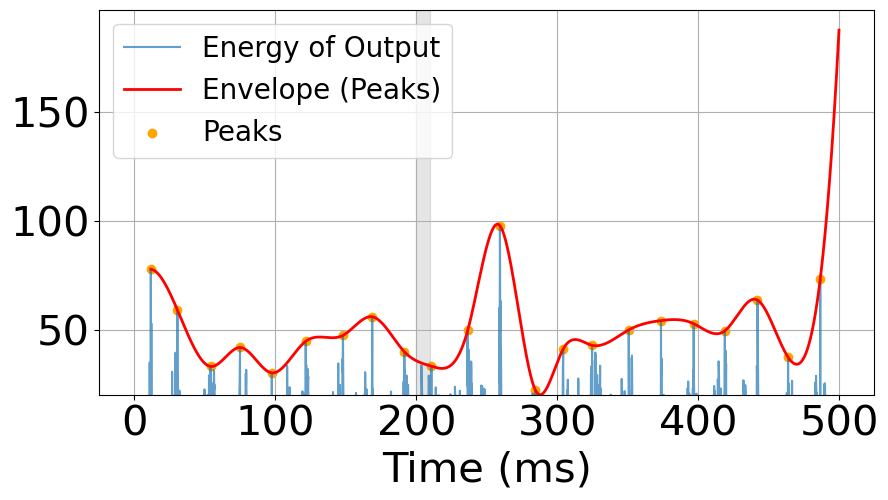

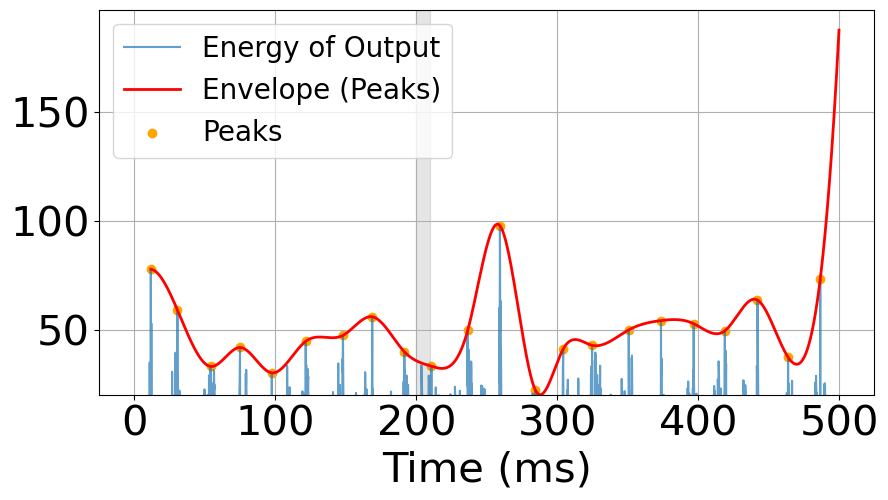

In [27]:

# 绘制 Go 和 Nogo 信号的包络线
time = np.array(range(len(Input_go[0])))*dt # 时间轴
peak_indx_go, peak_times_go, peak_values_go, env_go = peak_envelope(go_signal**2, time,dt)
peak_indx_nogo, peak_times_nogo, peak_values_nogo, env_nogo = peak_envelope(nogo_signal**2,time,dt)

# 绘制 Go 和 Nogo 信号的包络线
fig, ax = plt.subplots(figsize=(10,5))
plot_peak_envelope(ax,time, go_signal**2, peak_indx_go, env_go, peak_times_go, peak_values_go, 'Go', Input_go)
ax.legend(fontsize=20)
ylim = ax.get_ylim()
fig, ax = plt.subplots(figsize=(10,5))
plot_peak_envelope(ax,time, nogo_signal**2, peak_indx_nogo, env_nogo, peak_times_nogo, peak_values_nogo, 'Nogo', Input_nogo, ylim=ylim)
ax.legend(fontsize=20)


In [16]:
# calculate the inner product of the bias and the stimuli go
print('Inner product of the bias and the stimuli go:')
print(np.dot(bias[:N_E,0].cpu().numpy(),Sti_go[:N_E,0]))
print('-----------------------------------')
# print(np.dot(np.ones(N_E)*eta_E,Sti_go[:N_E,0]))
# calculate the inner product of the stimuli go and nogo
print('Inner product of the stimuli go and nogo:')
print(np.dot(Sti_go[:N_E,0],Sti_nogo[:N_E,0]))
print('-----------------------------------')
# calculate the inner product of the n and nogo
print('Inner product of the m and nogo:')
print(np.dot(m[:N_E,0],Sti_nogo[:N_E,0]))
print('-----------------------------------')
# calculate the inner product of the stimuli go and m
print('Inner product of the stimuli go and m:')
print(np.dot(Sti_go[:N_E,0],m[:N_E,0]))
print('-----------------------------------')
# sum of all the element in m and n and Sti_nogo
print('Sum of all the element in m and n and Sti_nogo:')
print(np.sum(m[:N_E]))
print(np.sum(n[:N_E]))
print(np.sum(Sti_nogo[:N_E]))
print('-----------------------------------')


# # test
# i = 0
# while i<100:
#     m_test, n_test, Sti_nogo_test = Generate_Vectors(N, mu, si)
#     # if torch.sum(m_test[:N_E]).abs() < 1 and torch.sum(n_test[:N_E]).abs() < 1 and torch.sum(Sti_nogo_test[:N_E]).abs() < 1:
#     #     print(N,mu,si)
#     #     # sum of all the element in m and n and Sti_nogo_test
#     #     print(torch.sum(m_test[:N_E]))
#     #     print(torch.sum(n_test[:N_E]))
#     #     print(torch.sum(Sti_nogo_test[:N_E]))
#     #     print('i:',i)
#     #     print('-----------------------------------')
#     #     break
#     print(np.dot(bias[:N_E,0].cpu().numpy(),n_test[:N_E,0]))
#     if np.abs(np.dot(bias[:N_E,0].cpu().numpy(),n_test[:N_E,0]))< 1:
#         print('i:',i)
#         print('-----------------------------------')
#         break
#     else :
#         print('i:',i)
#     i += 1


Inner product of the bias and the stimuli go:
-1.792942
-----------------------------------
Inner product of the stimuli go and nogo:
0.024905205
-----------------------------------
Inner product of the m and nogo:
-1.1831977
-----------------------------------
Inner product of the stimuli go and m:
-1.0112917
-----------------------------------
Sum of all the element in m and n and Sti_nogo:
-0.5351529
0.9729848
0.05940652
-----------------------------------


In [87]:
# 把m,n,Sti_go,Sti_nogo变回tensor
m = torch.tensor(m)
n = torch.tensor(n)
Sti_go = torch.tensor(Sti_go)
Sti_nogo = torch.tensor(Sti_nogo)

T_pre = 225
T_sti = 10
T_after = 490-T_pre

# IS=25
IS=10

T = T_pre+T_sti+T_after # length of Period time (ms）

Input_go = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt))) #size:(N,time)
Input_go[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = Sti_go
Input_nogo = torch.zeros((LRSNN.N_E+LRSNN.N_I,int(T/dt)))
Input_nogo[:,int(T_pre/dt):int((T_pre+T_sti)/dt)] = Sti_nogo

# # duplicate the input for twice
# Input_go = torch.cat((Input_go,Input_go),1)
# Input_nogo = torch.cat((Input_nogo,Input_nogo),1)

# bias current (according to sugino's code)
# Eta = [0, 10]; % 定常電流の平均値
# Delta = [0, 0.05]; % 定常電流のHMHW
# I_E = Eta(1)+Delta(1)*tan(pi*((1:N_E)'/(N_E+1)-1/2)); % 流入電流(E)
# I_I = Eta(2)+Delta(2)*tan(pi*((1:N_I)'/(N_I+1)-1/2)); % 流入電流(I)
bias = torch.zeros_like(Input_go)
bias[:N_E,:] = (eta_E+delta_E*torch.tan(torch.tensor(np.pi*(np.arange(1,N_E+1)/(N_E+1)-1/2)))).unsqueeze(1)
bias[N_E:,:] = (eta_I+delta_I*torch.tan(torch.tensor(np.pi*(np.arange(1,N_I+1)/(N_I+1)-1/2)))).unsqueeze(1)

# Input_go += bias
# Input_nogo += bias

#将模型及相应属性移动到GPU
device = torch.device('cuda:0')
LRSNN = LRSNN.to(device)
Input_go = Input_go.to(device)
Input_nogo = Input_nogo.to(device)
bias = bias.to(device)

# Start Simulation
Out_go, V_go, g_go, I_syn_go, spk_step_go, spk_ind_go, spk_go, phase_go = LRSNN(dt,IS*Input_go+bias)
# Out_nogo, V_nogo, g_nogo, I_syn_nogo, spk_step_nogo, spk_ind_nogo, spk_nogo, phase_nogo = LRSNN(dt,IS*Input_nogo+bias)


g_go_EE = g_go[1]
# g_nogo_EE = g_nogo[1]
# Out_go = torch.matmul(LRSNN.W_out[:N_E].T, g_go_EE).squeeze()
# Out_nogo = torch.matmul(LRSNN.W_out[:N_E].T, g_nogo_EE).squeeze()
# prop = torch.max(Out_go)/torch.max(Out_nogo)
# print('Performance: ', prop.item())


/tmp/ipykernel_3794193/4261778663.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  m = torch.tensor(m)
/tmp/ipykernel_3794193/4261778663.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n = torch.tensor(n)
/tmp/ipykernel_3794193/4261778663.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Sti_go = torch.tensor(Sti_go)
/tmp/ipykernel_3794193/4261778663.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Start Simulation
Simulation Finished


In [36]:
LRSNN = load_init(LRSNN, T-dt, dt, g_go[0], g_go[1], g_go[2], g_go[3], g_go[4], V_go, phase_go, I_syn_go[0], I_syn_go[1], I_syn_go[2], I_syn_go[3], I_syn_go[4], spk_go)

Initial values have been loaded.


In [88]:
# 处理绘图用的数据以使其能够在cpu上运行
Out_go = Out_go.cpu().numpy()
# Out_nogo = Out_nogo.cpu().numpy()
Input_go = Input_go.cpu().numpy()
Input_nogo = Input_nogo.cpu().numpy()
g_go = [g.cpu().numpy() for g in g_go]
# g_nogo = [g.cpu().numpy() for g in g_nogo]
g_go_EE = g_go[1]
# g_nogo_EE = g_nogo[1]
V_go = V_go.cpu().numpy()
# V_nogo = V_nogo.cpu().numpy()
I_syn_go = [I.cpu().numpy() for I in I_syn_go]
# I_syn_nogo = [I.cpu().numpy() for I in I_syn_nogo]
I_syn_go_EE = I_syn_go[1]
# I_syn_nogo_EE = I_syn_nogo[1]

# spk_go = spk_go.cpu().numpy()
# spk_nogo = spk_nogo.cpu().numpy()
m = m.cpu().numpy()
n = n.cpu().numpy()
Sti_go = Sti_go.cpu().numpy()
Sti_nogo = Sti_nogo.cpu().numpy()

(-29.400716018676757, 26.133565139770507)

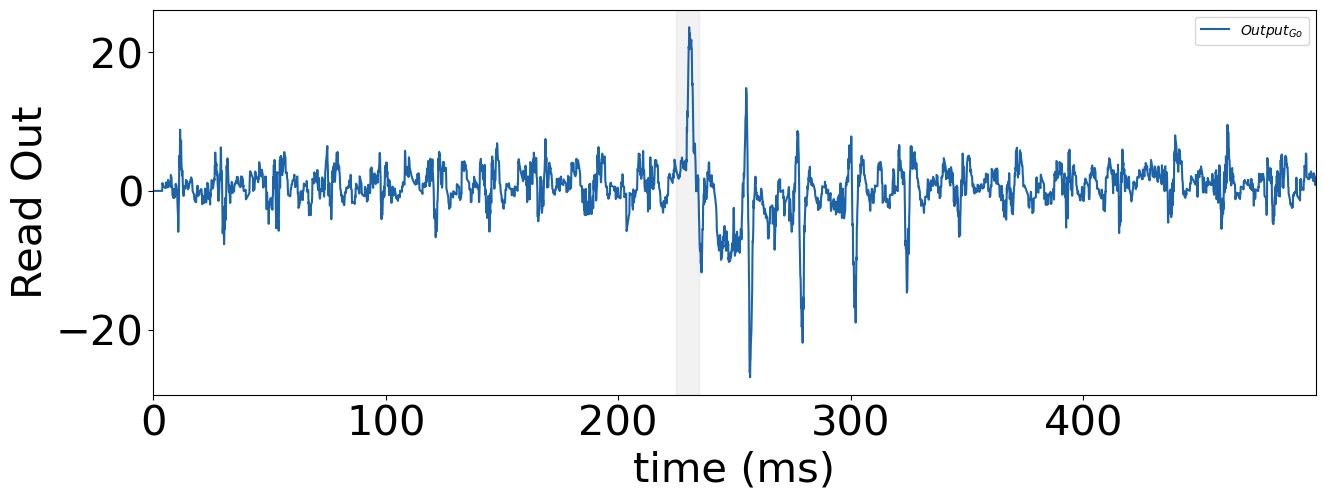

In [89]:
# Draw Output
fig, ax = plt.subplots(figsize=(15,5))
# ax.set_ylim([-20,20])
Draw_Output(ax,Out_go,'Output_{Go}',dt,Input_go,color_data = color_Go)

# fig, ax = plt.subplots(figsize=(15,5))
# # ax.set_ylim([-20,20])
# Draw_Output(ax,Out_nogo,'Output_{Nogo}',dt,Input_nogo,color_data=color_Nogo)


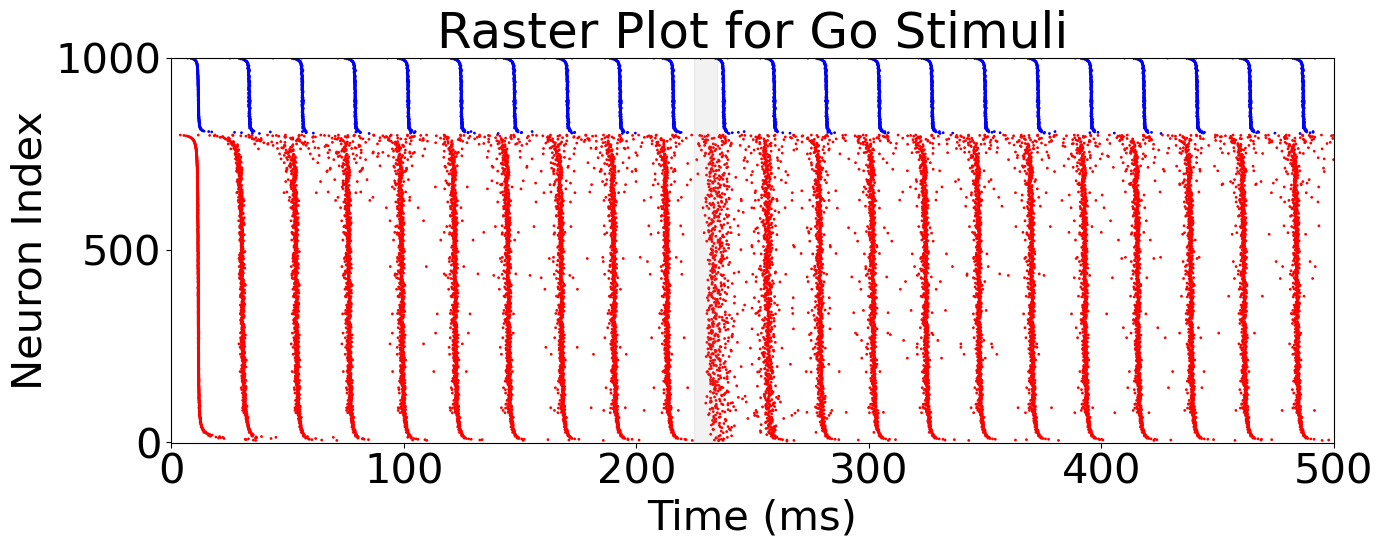

In [90]:

# Raster Plot
fig, ax = plt.subplots(figsize=(15,5))
Draw_RasterPlot(ax,spk_step_go, spk_ind_go,'Raster Plot for Go Stimuli',dt,Input_go,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())
# fig, ax = plt.subplots(figsize=(15,5))
# Draw_RasterPlot(ax,spk_step_nogo,spk_ind_nogo,'Raster Plot for Nogo Stimuli',dt,Input_nogo,LRSNN.N_E.cpu(),LRSNN.N_I.cpu())


Text(0.5, 0, 'Time (ms)')

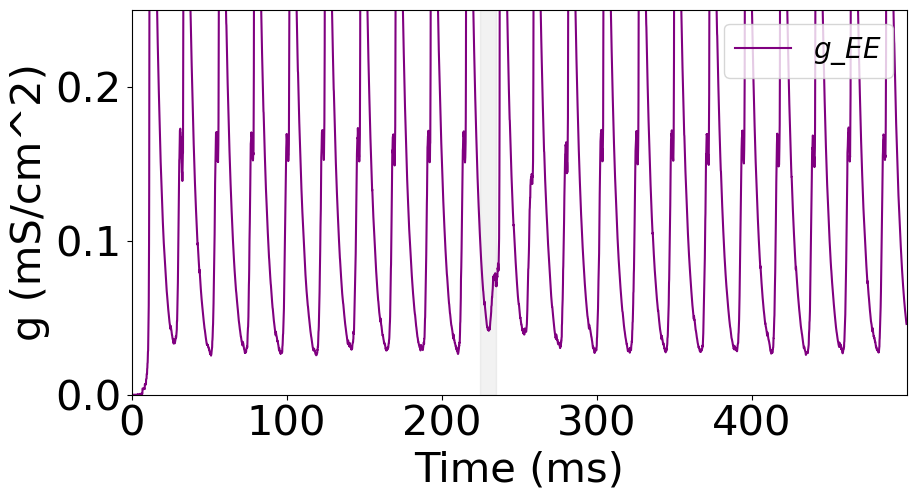

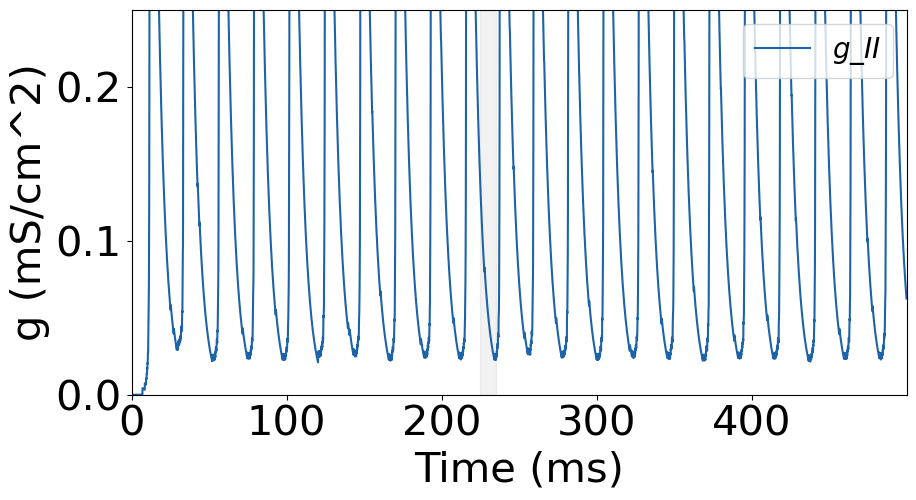

In [91]:
fig, ax = plt.subplots(figsize=(10,5))
# Draw_Conductance(ax,g_go,colors,tag,dt,Input_go,ylim=y_lim,title="Synaptic Conductance for Go")
Draw_Conductance(ax,g_go[0],'#800080','g\_EE',dt,Input_go,ylim=y_lim)
ax.legend(loc = 1, prop={'size':20})
ax.set_xlabel('Time (ms)')

fig, ax = plt.subplots(figsize=(10,5))
# Draw_Conductance(ax,g_go,colors,tag,dt,Input_go,ylim=y_lim,title="Synaptic Conductance for Go")
Draw_Conductance(ax,g_go[-1],'#1C63A9','g\_II',dt,Input_go,ylim=y_lim)
ax.legend(loc = 1, prop={'size':20})
ax.set_xlabel('Time (ms)')

(-80.0, 40.0)

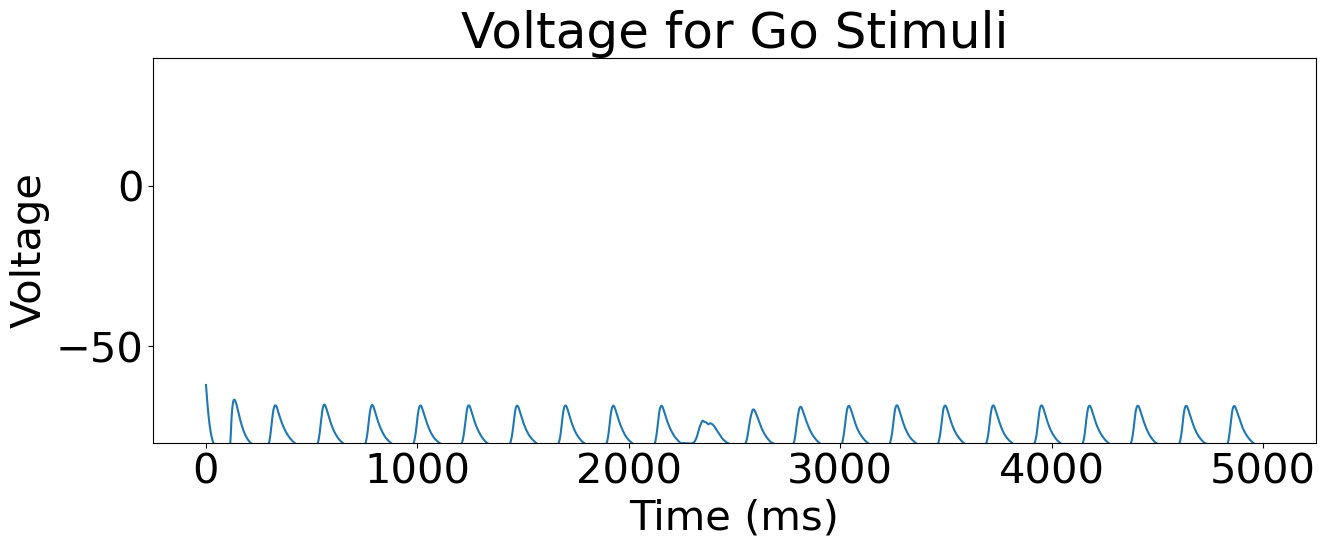

In [92]:
# print(V_go[:,1])
# monitor the voltage
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(V_go[0,:])
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Voltage')
ax.set_title('Voltage for Go Stimuli')
ax.set_ylim([-80,40])
# fig, ax = plt.subplots(figsize=(15,5))



Text(0.5, 0, 'Time (ms)')

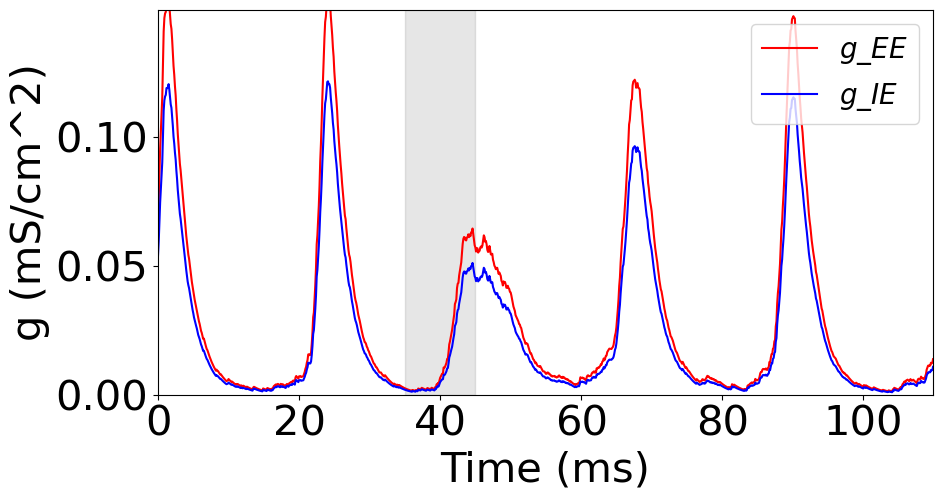

In [95]:
fig, ax = plt.subplots(figsize=(10,5))
start = 1900
end = 3000
Draw_Conductance(ax,g_go[1][:,start:end],'red','g\_EE',dt,Input_go[:,start:end])
# Draw_Conductance(ax,g_go[2][:,start:end],'green','g\_EI',dt,Input_go[:,start:end])
Draw_Conductance(ax,g_go[3][:,start:end],'blue','g\_IE',dt,Input_go[:,start:end])
# Draw_Conductance(ax,g_go[4][:,start:end],'#1C63A9','g\_II',dt,Input_go[:,start:end])
ax.legend(loc = 1, prop={'size':20})
ax.set_xlabel('Time (ms)')


Text(0.5, 0, 'Time (ms)')

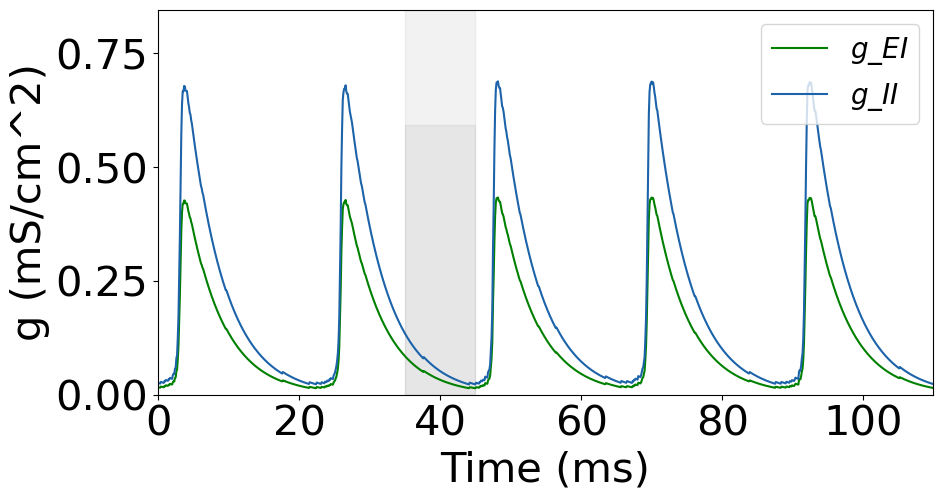

In [96]:
fig, ax = plt.subplots(figsize=(10,5))
start = 1900
end = 3000
# Draw_Conductance(ax,g_go[1][:,start:end],'red','g\_EE',dt,Input_go[:,start:end])
Draw_Conductance(ax,g_go[2][:,start:end],'green','g\_EI',dt,Input_go[:,start:end])
# Draw_Conductance(ax,g_go[3][:,start:end],'blue','g\_IE',dt,Input_go[:,start:end])
Draw_Conductance(ax,g_go[4][:,start:end],'#1C63A9','g\_II',dt,Input_go[:,start:end])
ax.legend(loc = 1, prop={'size':20})
ax.set_xlabel('Time (ms)')